In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import arviz as az
import astropy.cosmology as cosmo
from astropy.cosmology import Planck18
import astropy.units as u
import dataclasses
from dataclasses import dataclass
from glob import glob
import h5py
import intensity_models
from intensity_models import make_pop_model, make_pop_cosmo_model
import lal
import lalsimulation as ls
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
import re
import scipy.stats as ss
import seaborn as sns
import time
from tqdm.notebook import tqdm
from utils import pt_interp, pt_cumtrapz
import weighting

sns.set_theme('notebook', 'ticks', 'colorblind')

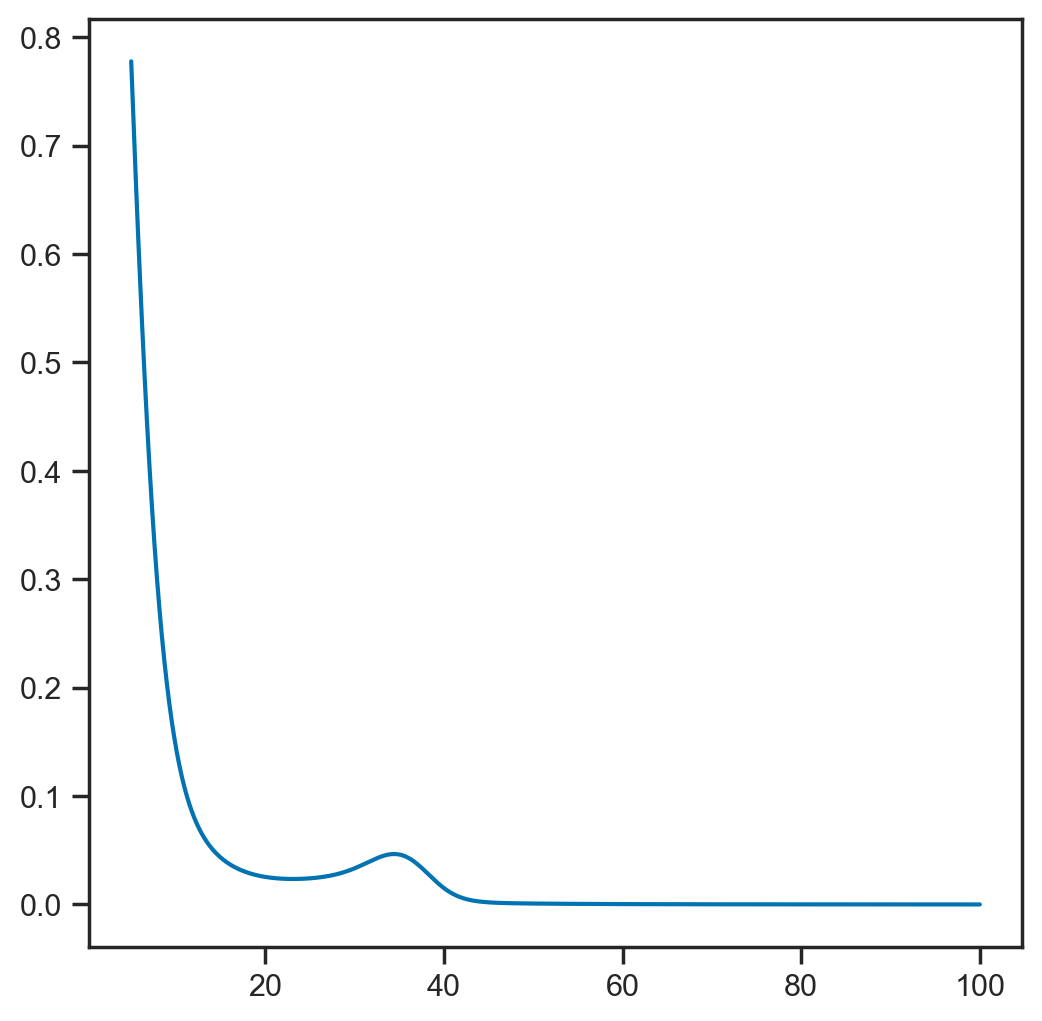

In [3]:
m = np.linspace(5, 100, 1024)
plt.plot(m, np.exp(weighting.default_log_dNdmdqdV(m, np.ones_like(m), np.zeros_like(m))))

In [4]:
inj = pd.read_hdf('../data/mock_injections.h5', key='true_parameters')

In [10]:
obs = pd.read_hdf('../data/mock_observations.h5', 'observations')
obs['m1_det'] = obs['m1']*(1 + obs['z'])
obs['dl'] = Planck18.luminosity_distance(obs['z'].to_numpy()).to(u.Gpc).value

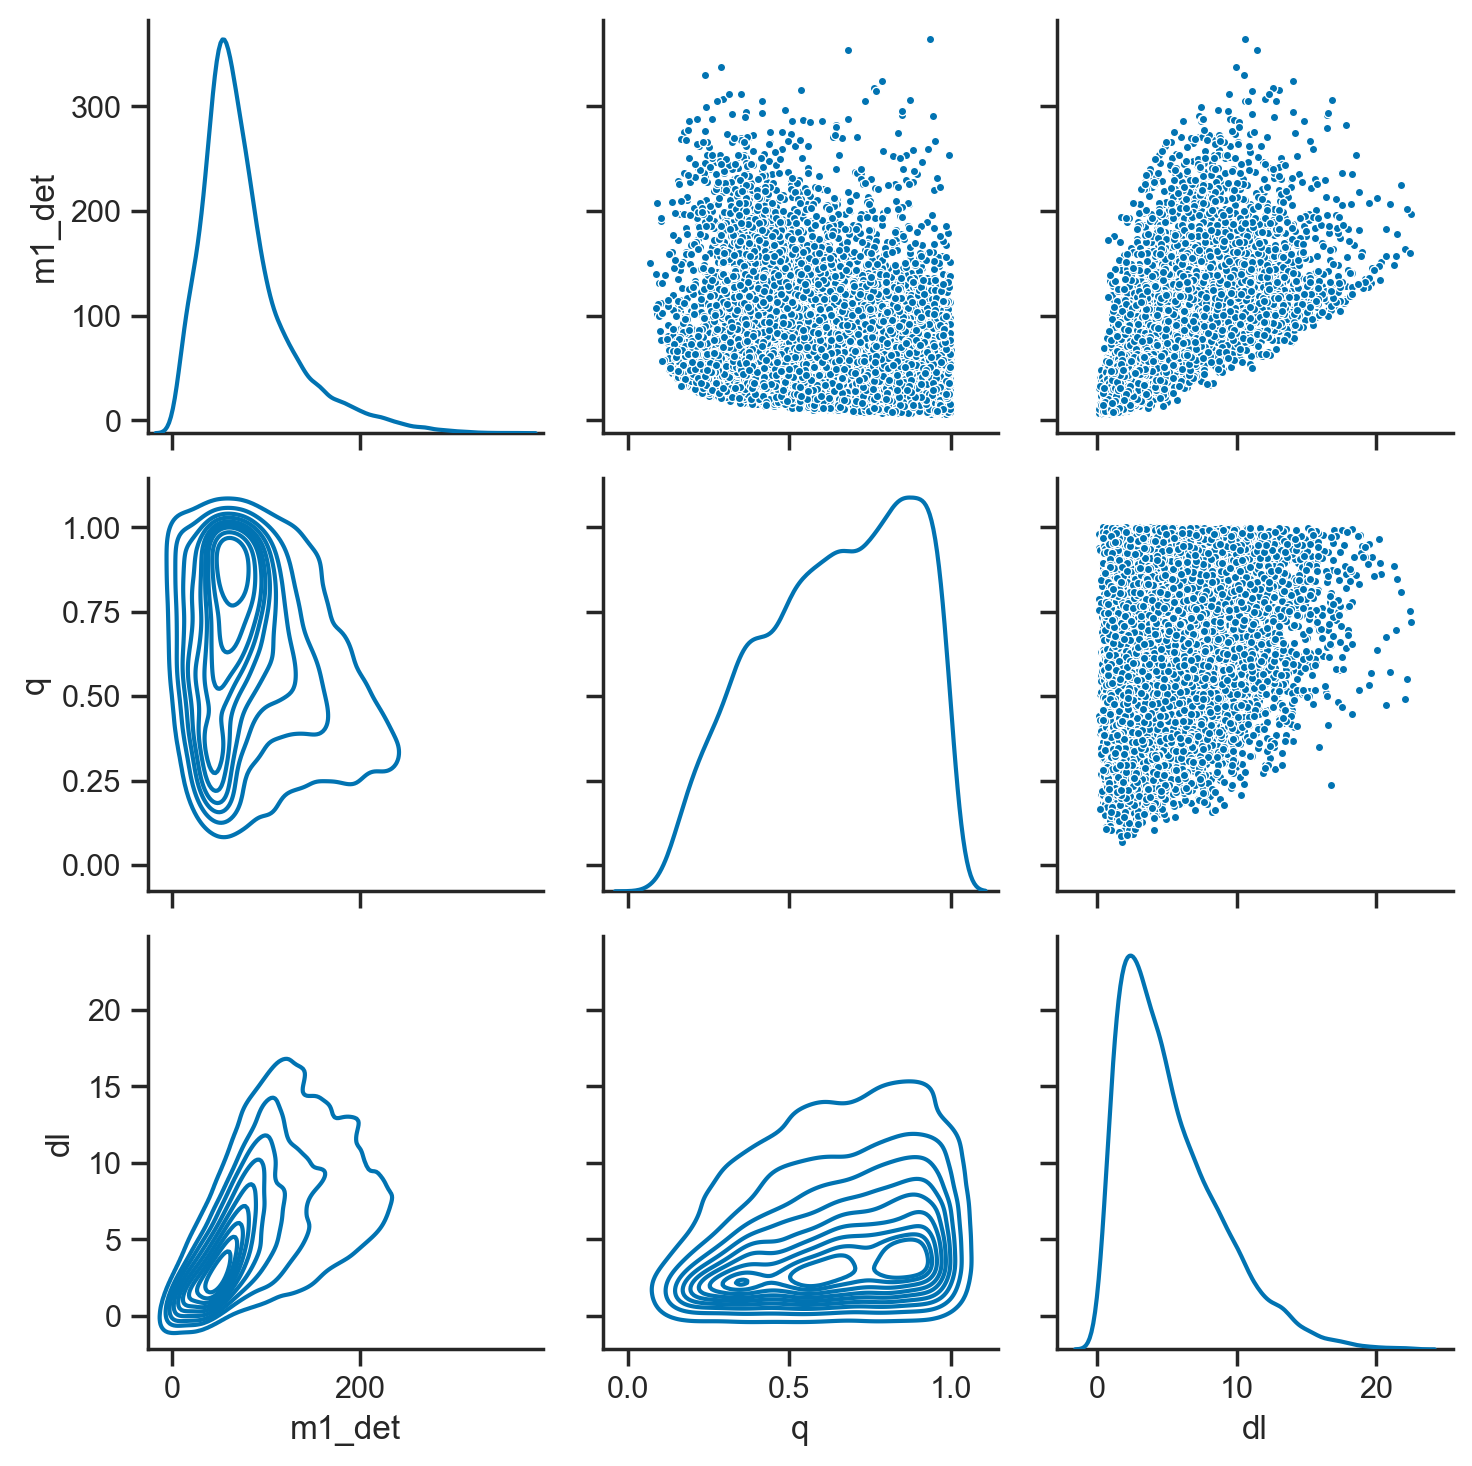

In [11]:
pg = sns.PairGrid(obs[['m1_det', 'q', 'dl']], diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_lower(sns.kdeplot)
pg.map_upper(sns.scatterplot, marker='.')